<a href="https://colab.research.google.com/github/ndecavel/tdwi-llm/blob/main/%5BMAIN%5D_Lab_3_Improving_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: RAG Improvements

In this section, we will use our metric-driven experimentation to improve our RAG system. We will do so by:
1. Implementing LlamaParse
2. Implementing hybrid search
3. Exploring the input prompts for llama-index RAG implementations.

_____
## Imports + Downloads

Previously we downloaded from FlagEmbedding to allow for Milvus hybrid search. In particular, this will allow access to the BGE family of models. (https://github.com/FlagOpen/FlagEmbedding). That being said, newer versions of Milvus allow us to natively handle this within our pip install pymilvus[model] package.

**FlagEmbedding** focuses on retrieval-augmented LLMs, consisting of the following projects currently:

- Long-Context LLM: Activation Beacon, LongLLM QLoRA
- Fine-tuning of LM : LM-Cocktail
- Embedding Model: Visualized-BGE, BGE-M3, LLM Embedder, BGE Embedding
- Reranker Model: llm rerankers, BGE Reranker
- Benchmark: C-MTEB, AIR-Bench, MLVU

In [ ]:
import os
import pandas as pd


from litellm import completion
from datasets import Dataset

from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)
from pymilvus import MilvusClient
from pymilvus import model
from pymilvus import (
    utility,
    FieldSchema, CollectionSchema, DataType,
    Collection, AnnSearchRequest, RRFRanker, connections,
)

In [ ]:
TDS_FOLDER_PATH = "../data/downloaded_pdfs/"
NAIVE_COLLECTION_NAME = "Naive_RAG"
IMPROVED_COLLECTION_NAME = "Improved_RAG"
BEHR_FILE_PATH = '../data/Behr_all_products.xlsx'


In [ ]:
### Set ENV Variables
os.environ["OPENAI_API_KEY"] = ### Insert OPENAI API KEY

os.environ["GEMINI_API_KEY"] = ### Insert GEMINI API KEY

os.environ["LLAMA_CLOUD_API_KEY"]= ### Insert Llama Cloud API Key


### Zilliz API Info
os.environ["ZILLIZ_API_KEY"] = ### Insert Zilliz API KEY

os.environ["CLOUD_REGION"] = ### Zilliz cloud region

os.environ["CLUSTER_ID"] = ### Zilliz cluster id

os.environ["PROJECT_ID"] = ### Zilliz project id

os.environ["CLUSTER_ENDPOINT"] = ### Zilliz endpoint



____

In [ ]:
df = pd.read_excel(BEHR_FILE_PATH)
df['File Name'] = df['TDS Link'].apply(lambda x: x.split('/')[-1].upper().replace('HTML', 'pdf'))
df.sample(3)

In [ ]:
golden_df = pd.read_csv('../data/Golden_Test_Data_DeepEval.csv')
golden_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
golden_df = golden_df.rename(columns={'input':'question', 'expected_output':'ground_truth'})

The above sample shows the information that was used in compiling our dataset for this hands-on component.

The following code was used to embed my documents via Llama Parse. Note that this code takes quite awhile to run and there are more optimized ways to do this outside of a notebook environment (batching directly within the Llama Parse interface for example)

```python
nest_asyncio.apply()

parser = LlamaParse(
    api_key='',
    result_type="markdown",  # "markdown" and "text" are available
    verbose=True,
)

file_extractor = {".pdf": parser}
documents = SimpleDirectoryReader(TDS_FOLDER_PATH, file_extractor=file_extractor
).load_data()

```

### Read more about Llama Parse here! https://www.llamaindex.ai/blog/launching-the-first-genai-native-document-parsing-platform

LlamaParse, developed by LlamaIndex, is the first GenAI-native document parsing platform, designed to harness the power of large language models (LLMs) for advanced document processing. Since its public release, it has attracted over 2,000 users and parsed over a million pages. Key features include:

- **GenAI-powered parsing instructions**: Users can give simple, natural-language directives to the parser, improving accuracy and efficiency for various document types, including rich tables, translated manga, and complex mathematical equations. This feature also enables tasks like sentiment analysis, language simplification, and translation.

- **JSON mode**: Provides a detailed programmatic format for precise parsing requirements. Outputs include:
  - Document structure
  - Marked tables, text, and headings
  - Images with metadata
  - CSV and JSON formats for tables

LlamaParse supports a wide range of document types beyond PDFs, such as Microsoft Word, PowerPoint, Rich Text Format, Apple Pages, and ePub books.

### Understanding hybrid search with RFR:

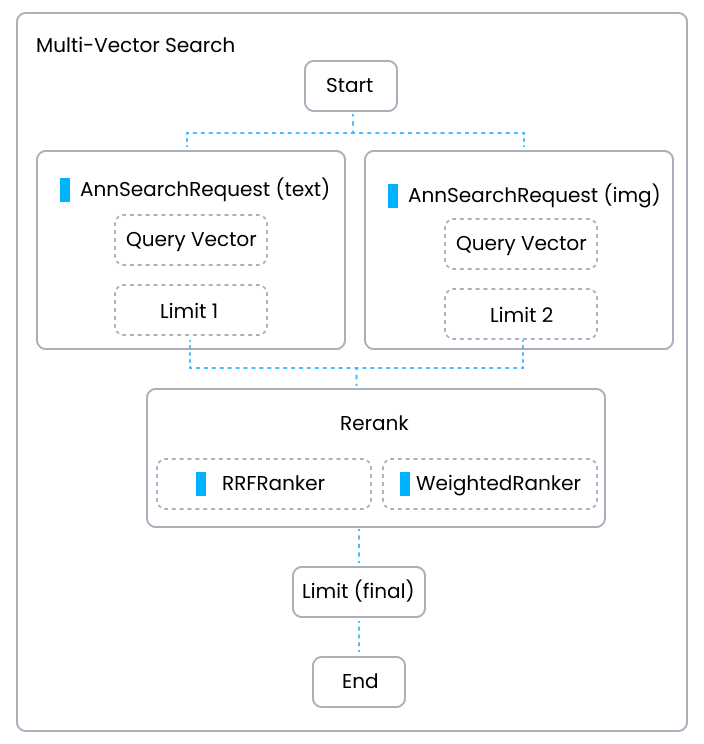

#### Weighted Scoring (WeightedRanker)
The WeightedRanker strategy assigns different weights to results from each vector retrieval route based on the significance of each vector field. This reranking strategy is applied when the significance of each vector field varies, allowing you to emphasize certain vector fields over others by assigning them higher weights. For example, in a multimodal search, the text description might be considered more important than the color distribution in images.


#### Reciprocal Rank Fusion (RRFRanker)


RRF is a data fusion method that combines ranking lists based on the reciprocal of their ranks. It is an effective way to balance the influence of each vector field, especially when there is no clear precedence of importance. This strategy is typically used when you want to give equal consideration to all vector fields or when there is uncertainty about the relative importance of each field.




(Context from Milvus documentation)

In [ ]:
import openai

def emb_text(text):
    return (
        openai.OpenAI().embeddings.create(input=text, model="text-embedding-3-small")
        .data[0]
        .embedding
    )

bge_m3_ef = model.hybrid.BGEM3EmbeddingFunction(
    model_name='BAAI/bge-m3', # Specify the model name
    device='cpu', # Specify the device to use, e.g., 'cpu' or 'cuda:0'
    use_fp16=False # Specify whether to use fp16. Set to `False` if `device` is `cpu`.
)

In [ ]:
import tqdm

# 1. Initialize our client
milvus_client = MilvusClient(os.getenv("CLUSTER_ENDPOINT"),
                             token=os.getenv("ZILLIZ_API_KEY"))

# Prepare index parameters
index_params = milvus_client.prepare_index_params()

# Add indexes
index_params.add_index(
    field_name="dense",
    index_name="dense_index",
    index_type="IVF_FLAT",
    metric_type="IP",
    params={"nlist": 128},
)

index_params.add_index(
    field_name="sparse",
    index_name="sparse_index",
    index_type="SPARSE_INVERTED_INDEX",  # Index type for sparse vectors
    metric_type="IP",  # Currently, only IP (Inner Product) is supported for sparse vectors
    params={"inverted_index_algo": "DAAT_MAXSCORE"},  # The ratio of small vector values to be dropped during indexing
)

fields = [
  FieldSchema(name="id", dtype=DataType.INT64, is_primary=True),
  FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=65535),
  FieldSchema(name="dense", dtype=DataType.FLOAT_VECTOR, dim=1024),
  FieldSchema(name="sparse", dtype=DataType.SPARSE_FLOAT_VECTOR)
]

schema = CollectionSchema(fields=fields, auto_id=False, enable_dynamic_field=True, description="Improved RAG with Llama Parse")


# 2. If it already exists, no need to go through the data ingestion pipeline again.
insert_data = True
if milvus_client.has_collection(IMPROVED_COLLECTION_NAME):
  num_rows = milvus_client.get_collection_stats(IMPROVED_COLLECTION_NAME)['row_count']
  if num_rows >20:
    print(f"Collection '{IMPROVED_COLLECTION_NAME}' already exists.")
    insert_data = False

### In order to actually run llama parse and insert these documents, I used the following code:
"""
# parser = LlamaParse(
#     api_key=LLAMA_CLOUD_API_KEY,  # can also be set in your env as LLAMA_CLOUD_API_KEY
#     result_type="markdown",  # "markdown" and "text" are available
#     verbose=True,
# )

# file_extractor = {".pdf": parser}
# documents = SimpleDirectoryReader(TDS_FOLDER_PATH, file_extractor=file_extractor
# ).load_data()

vector_store = MilvusVectorStore(uri=os.getenv("CLUSTER_ENDPOINT"),
                             token=os.getenv("ZILLIZ_API_KEY"),
                              dim=1536,
                              collection_name=IMPROVED_COLLECTION_NAME,
                              overwrite=False,
                              enable_sparse=True,
                              hybrid_ranker="RRFRanker",
                              hybrid_ranker_params={"k": 60},
                          )

# Create an index over the documnts
# from llama_index.core import StorageContext
# storage_context = StorageContext.from_defaults(vector_store=vector_store)
# index = VectorStoreIndex.from_documents(
#     documents, storage_context=storage_context
# )
"""
### Lab purposes only: Commenting out below code to avoid long run time
# else:
#   milvus_client.create_collection(
#         collection_name=IMPROVED_COLLECTION_NAME,
#         schema=schema,
#         index_params=index_params
#     )

# if insert_data:
#     ## 2a. In order to avoid re-running Llama Parse, we will be pulling from Nic's backup run
#     prev_results = milvus_client.query(collection_name="Nicolas36_Improved_RAG_backup", filter="", limit=1000)

#     def process_res(res, i):
#         text = json.loads(res['_node_content'])['text']
#         embeddings = bge_m3_ef([text])
#         dense = embeddings['dense'][0]
#         sparse = embeddings['sparse']
#         return {"id": i, "dense": dense, "sparse": sparse, "text": text}

#     data = [process_res(res, i) for i, res in tqdm.tqdm(enumerate(prev_results[10:]))]

#     milvus_client.insert(collection_name=IMPROVED_COLLECTION_NAME, data=data)

____
### Now that we've made a few changes, let us experiment with how this may improve our RAG system.

In [ ]:
from pymilvus import RRFRanker

def naive_search_context(question):
  search_res = milvus_client.search(
      collection_name=NAIVE_COLLECTION_NAME,
      data=[
          emb_text(question)
      ],
      limit=3,  # Return top 3 results
      search_params={"metric_type": "COSINE", "params": {}},  # Cosine distance
      output_fields=["text", "file_name"],  # Return the text field
    )
  return [res["entity"]["text"] for res in search_res[0]]

def hybrid_search_context(question):
  query_embeddings = bge_m3_ef([question])

  search_param_1 = {
      "data": [query_embeddings['dense'][0]],
      "anns_field": "dense",
      "param": {
          "metric_type": "IP",
          "params": {"nprobe": 10}
      },
      "limit": 5
  }
  request_1 = AnnSearchRequest(**search_param_1)

  search_param_2 = {
      "data": [query_embeddings['sparse']],
      "anns_field": "sparse",
      "param": {
          "metric_type": "IP",
          "params": {}
      },
      "limit": 3
  }
  request_2 = AnnSearchRequest(**search_param_2)

  reqs = [request_1, request_2]

  ranker = RRFRanker(60)


  res = milvus_client.hybrid_search(
      collection_name=IMPROVED_COLLECTION_NAME,
      reqs=reqs,
      ranker=ranker,
      limit=3,
      output_fields=["text"],
  )
  return [hit['entity']['text'] for hit in res[0]]


In [ ]:
def format_context(question, retrieved_context):
  context = "\n".join(retrieved_context)

  USER_PROMPT = f"""
  Use the following pieces of information enclosed in <context> tags to provide an answer to the question enclosed in <question> tags.
  <context>
  {context}
  </context>
  <question>
  {question}
  </question>
  """
  return USER_PROMPT


sample_test_df = golden_df.sample(25, random_state=30)

comparisons = [('naive', naive_search_context), ('improved', hybrid_search_context)]


naive_sample_rows = []
hybrid_sample_rows = []
for idx, row in tqdm.tqdm(sample_test_df.iterrows()):
  question = row['question']
  for name, func in comparisons:
    retrieved_context = func(question)
    formatted_input = format_context(question, retrieved_context)
    SYSTEM_PROMPT = "Human: You are an AI assistant. You are able to find answers to the questions from the contextual passage snippets provided."

    messages_chat = [
        {"content": SYSTEM_PROMPT, "role": "system"},
        {"content": formatted_input, "role": "user"}
        ]

    ### Note: We can add streaming in order to help with seeing the initial outputs sooner.
    for model in ['gemini/gemini-1.5-flash', 'gemini/gemini-1.5-pro', 'openai/gpt-4o-mini']:
      temp_info = {'question': question}
      temp_info['ground_truth'] = row['ground_truth']
      response = completion(model=model, messages=messages_chat, temperature=0.2)
      temp_info['model'] = model
      temp_info['answer'] = response.choices[0].message.content
      temp_info['contexts'] = retrieved_context
      if name == 'naive':
        naive_sample_rows.append(temp_info)
      else:
        hybrid_sample_rows.append(temp_info)

In [ ]:
naive_df = pd.DataFrame(naive_sample_rows)
hybrid_df = pd.DataFrame(hybrid_sample_rows)

In [ ]:
naive_results = {}

for model, subset in naive_df.groupby('model'):
  naive_results[model] = evaluate(
    Dataset.from_pandas(subset),
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
)


In [ ]:
hybrid_results = {}

for model, subset in hybrid_df.groupby('model'):
  hybrid_results[model] = evaluate(
    Dataset.from_pandas(subset),
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
)


In [ ]:
naive_results

In [ ]:
hybrid_results